### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [1]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city,array_to_latex
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from qiskit.circuit.library.data_preparation.state_preparation import *
#9329 con 6 res
#seed 10 con resolution 5
#6476 cambiando eigenvalues a 0.55 e 0.45 ris=7
# 12 con 4x4 matrix e risoluzione 7
#500  4x4 cambiando autovalori.
#4524
#8908
#4747 res 8
#6752
np.random.seed(500)

example_matrix=np.random.rand(4,4)


example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix=np.array([[1.5,0.5],[0.5,1.5]])
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.10789793 0.02520744 0.0812551  0.07771501 0.02520744 0.01881271
 0.03875604 0.03396996 0.0812551  0.03875604 0.09665605 0.07484566
 0.07771501 0.03396996 0.07484566 0.11313487]


In [2]:
example_matrix,np.linalg.eig(example_matrix)

(array([[1.24208593, 0.6003568 , 1.07787997, 1.05413814],
        [0.6003568 , 0.51864561, 0.74441447, 0.69693555],
        [1.07787997, 0.74441447, 1.17560009, 1.03449502],
        [1.05413814, 0.69693555, 1.03449502, 1.27187177]]),
 (array([3.76854670e+00, 1.28015454e-03, 2.34299391e-01, 2.04077152e-01]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])))

In [3]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.29515824, 0.14266345, 0.2561378 , 0.250496  ],
        [0.14266345, 0.12324633, 0.17689603, 0.16561356],
        [0.2561378 , 0.17689603, 0.27935914, 0.24582819],
        [0.250496  , 0.16561356, 0.24582819, 0.30223629]]),
 (array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])))

In [4]:
eig,e_v=np.linalg.eig(example_matrix1)
#b=np.array([3,1])
#b=np.array([.6,.3,.07,0.03])
b=np.array([.7,.2,.06,0.04])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)
example_matrix2=BB

sum_squares = (example_matrix2**2).sum()
input_probabilities = (example_matrix2**2/sum_squares).flatten()
example_matrix2=example_matrix2/np.trace(example_matrix2)
print(input_probabilities)

[0.12606734 0.0423581  0.04966681 0.06023512 0.0423581  0.07828815
 0.00533715 0.02147962 0.04966681 0.00533715 0.15601336 0.08393026
 0.06023512 0.02147962 0.08393026 0.11361706]


In [5]:
example_matrix2,np.linalg.eig(example_matrix2)

(array([[0.25975226, 0.15056578, 0.16303888, 0.17954897],
        [0.15056578, 0.20469444, 0.05344567, 0.10721889],
        [0.16303888, 0.05344567, 0.28896081, 0.21194216],
        [0.17954897, 0.10721889, 0.21194216, 0.24659248]]),
 (array([0.7 , 0.2 , 0.06, 0.04]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])))

In [6]:
np.trace(example_matrix)*np.linalg.eig(example_matrix1)[0]

array([3.76854670e+00, 1.28015454e-03, 2.34299391e-01, 2.04077152e-01])

In [7]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [8]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [9]:
thetas, all_combinations = thetas_computation(example_matrix2)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.6525261399852201
1 -> 0.7577662150267647
00 -> 0.5275673971675836
01 -> 0.38400912073781823
10 -> 0.5430907613191465
11 -> 0.5284525159423302
000 -> 0.41039667854487305
001 -> 0.33151459212757894
010 -> 0.34734167986969816
011 -> 0.1637582432585559
100 -> 0.23452921648352562
101 -> 0.4898404042602383
110 -> 0.2858578906454516
111 -> 0.4444629657930026
0000 -> 0.3550596244455607
0001 -> 0.20581082782312804
0010 -> 0.22286051298011214
0011 -> 0.2454284346764985
0100 -> 0.20581082782312804
0101 -> 0.2798001889303555
0110 -> 0.07305576731934102
0111 -> 0.14655926138088535
1000 -> 0.22286051298011214
1001 -> 0.07305576731934102
1010 -> 0.39498526239224796
1011 -> 0.28970720415405743
1100 -> 0.24542843467649844
1101 -> 0.14655926138088538
1110 -> 0.2897072041540574
1111 -> 0.33707130376635613


┌────────────┐┌───┐              ┌───┐              ┌───┐              »
q_0: ┤ Ry(1.7198) ├┤ X ├──────■───────┤ X ├──────■───────┤ X ├──────■───────»
     └────────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐├───┤      │       »
q_1: ───────────────────┤ Ry(1.2584) ├─────┤ Ry(1.5435) ├┤ X ├──────■───────»
                        └────────────┘     └────────────┘└───┘┌─────┴──────┐»
q_2: ─────────────────────────────────────────────────────────┤ Ry(1.3589) ├»
                                                              └────────────┘»
q_3: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«     ┌───┐┌───┐               ┌───┐                                 ┌───┐»
«q_0: ┤ X ├┤ X ├───────■───────┤ X ├──────■──────────────────■───────┤ X ├»
«     ├───┤└───┘       │       ├───┤      │       ┌───┐      │       ├───┤»
«q_1: ┤ X ├────────────■───────┤ X ├──────■───────┤ X ├──────■───────┤ X ├»
«     └───┘     ┌──────┴──────┐└───┘┌─────┴──────┐└───┘┌─────┴──────┐├───┤»
«q_2: ──────────┤ Ry(0.88111) ├─────┤ Ry(2.2485) ├─────┤ Ry(1.9985) ├┤ X ├»
«               └─────────────┘     └────────────┘     └────────────┘└───┘»
«q_3: ────────────────────────────────────────────────────────────────────»
«                                                                         »
«                   ┌───┐┌───┐              ┌───┐┌───┐              ┌───┐┌───┐»
«q_0: ──────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├»
«           │       ├───┤├───┤      │       ├───┤└───┘      │       └───┘└───┘»
«q_1: ──────■───────┤ X ├┤ X ├──────■───────┤ X ├───────────■─────────────────»
«           │       ├───┤└───┘      │       ├───┤           │       ┌───┐     »
«q_2: ──────■───────┤ X ├───────────■───────┤ X ├───────────■───────┤ X ├─────»
«     ┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘     »
«q_3: ┤ Ry(1.0506) ├──────────┤ Ry(1.6671) ├──────────┤ Ry(1.8732) ├──────────»
«     └────────────┘          └────────────┘          └────────────┘          »
«                   ┌───┐                                            »
«q_0: ──────■───────┤ X ├───────■───────────────────────■────────────»
«           │       ├───┤       │       ┌───┐┌───┐      │       ┌───┐»
«q_1: ──────■───────┤ X ├───────■───────┤ X ├┤ X ├──────■───────┤ X ├»
«           │       ├───┤       │       ├───┤└───┘      │       ├───┤»
«q_2: ──────■───────┤ X ├───────■───────┤ X ├───────────■───────┤ X ├»
«     ┌─────┴──────┐└───┘┌──────┴──────┐└───┘     ┌─────┴──────┐└───┘»
«q_3: ┤ Ry(2.2167) ├─────┤ Ry(0.63354) ├──────────┤ Ry(1.2657) ├─────»
«     └────────────┘     └─────────────┘          └────────────┘     »
«                                      
«q_0: ──────■──────────────────■───────
«           │                  │       
«q_1: ──────■──────────────────■───────
«           │       ┌───┐      │       
«q_2: ──────■───────┤ X ├──────■───────
«     ┌─────┴──────┐└───┘┌─────┴──────┐
«q_3: ┤ Ry(1.0767) ├─────┤ Ry(1.7216) ├
«     └────────────┘     └────────────┘

In [10]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'0000': 0.126067336911423,
 '0001': 0.049666808245759,
 '0010': 0.042358096849241,
 '0011': 0.060235116547756,
 '0100': 0.049666808245759,
 '0101': 0.156013357507074,
 '0110': 0.005337145138618,
 '0111': 0.083930264138761,
 '1000': 0.042358096849241,
 '1001': 0.005337145138618,
 '1010': 0.078288145725462,
 '1011': 0.021479617096511,
 '1100': 0.060235116547756,
 '1101': 0.083930264138761,
 '1110': 0.021479617096511,
 '1111': 0.113617063822751}

In [11]:
#Unitary for PE
resolution = 8
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix2, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1475/2589655134.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix2, evolution_time=2*np.pi)


Operator([[ 0.50934983+0.03679191j, -0.37011352-0.10470294j,
           -0.25131265-0.48147828j, -0.32867899-0.43388147j],
          [-0.37011352-0.10470294j,  0.46653127+0.50177838j,
            0.04624173-0.52061898j, -0.16366965-0.28748936j],
          [-0.25131265-0.48147828j,  0.04624173-0.52061898j,
            0.3643449 +0.14344337j, -0.44613654-0.28191698j],
          [-0.32867899-0.43388147j, -0.16366965-0.28748936j,
           -0.44613654-0.28191698j,  0.55813365-0.06519922j]],
         input_dims=(2, 2), output_dims=(2, 2))

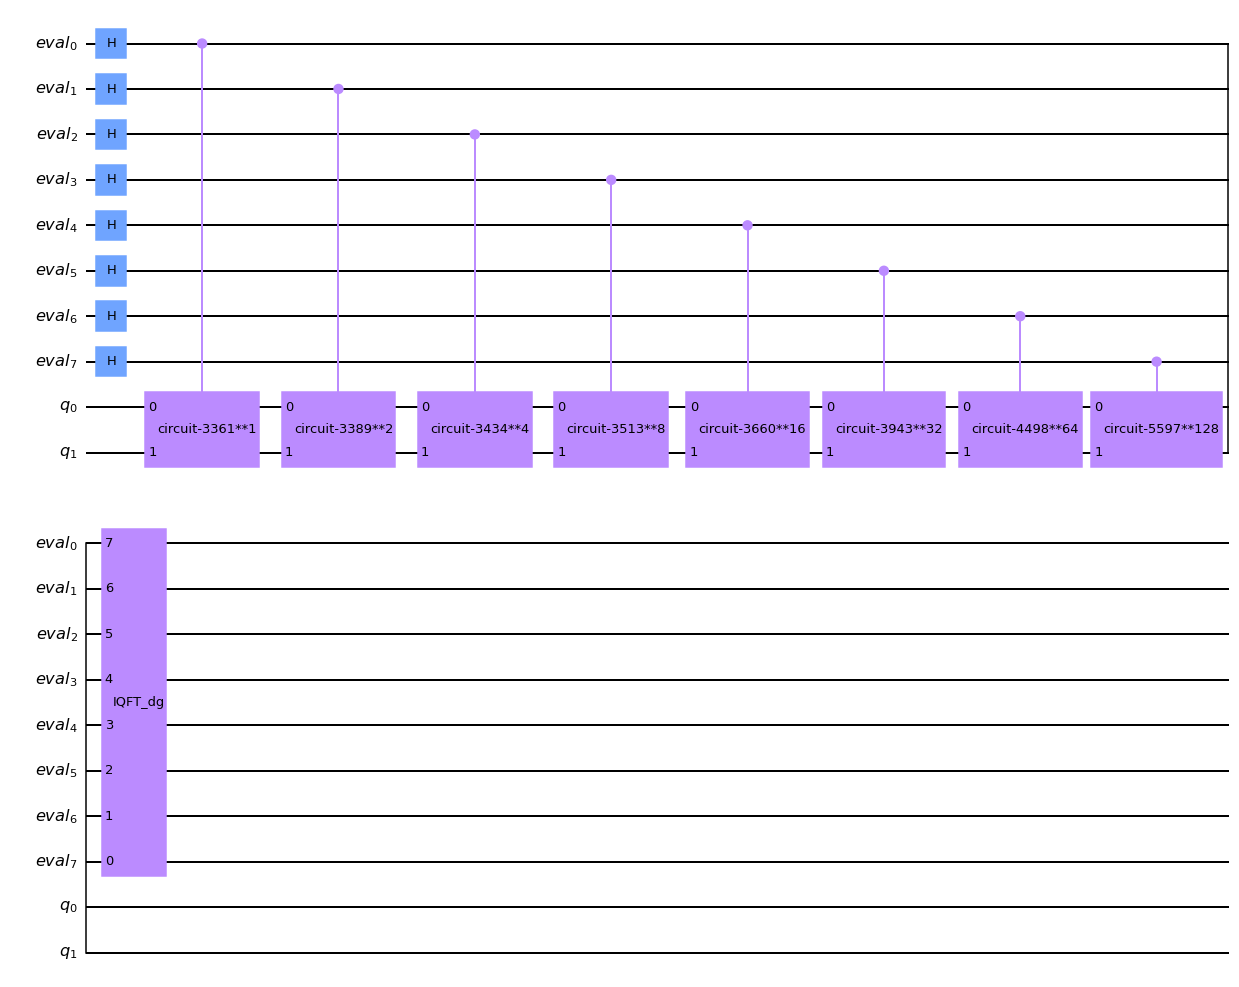

In [12]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

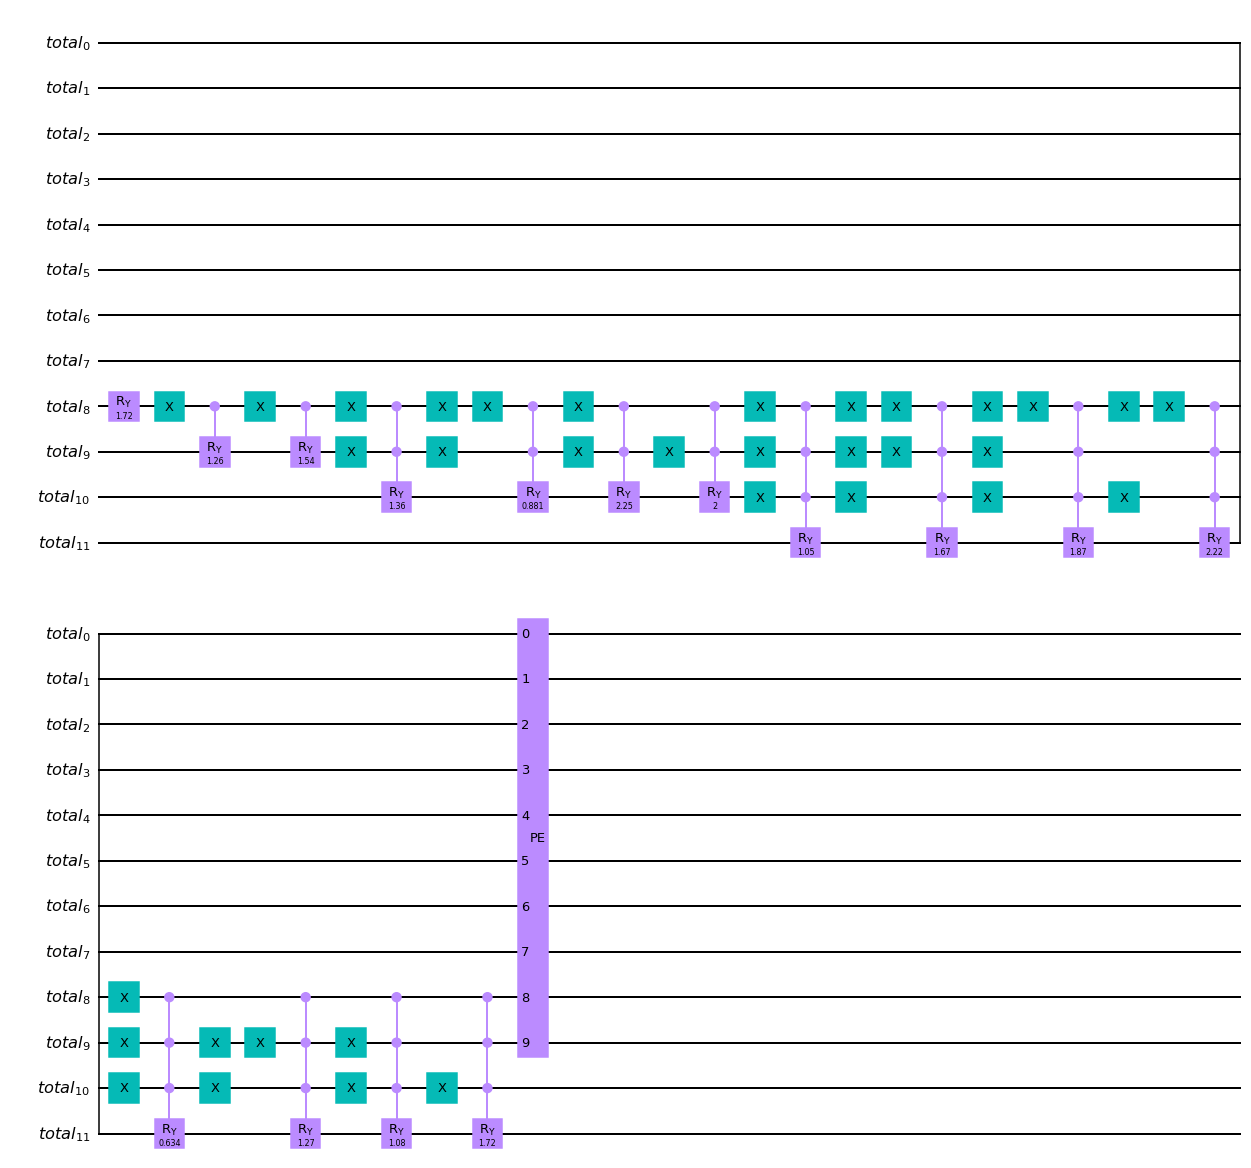

In [13]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim , name='matrix')

total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

In [14]:
# Create the first operator for tomography
op_U=total_circuit_sim.to_gate(label='op_U').control()

In [15]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit_sim, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [16]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [17]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(statevector)


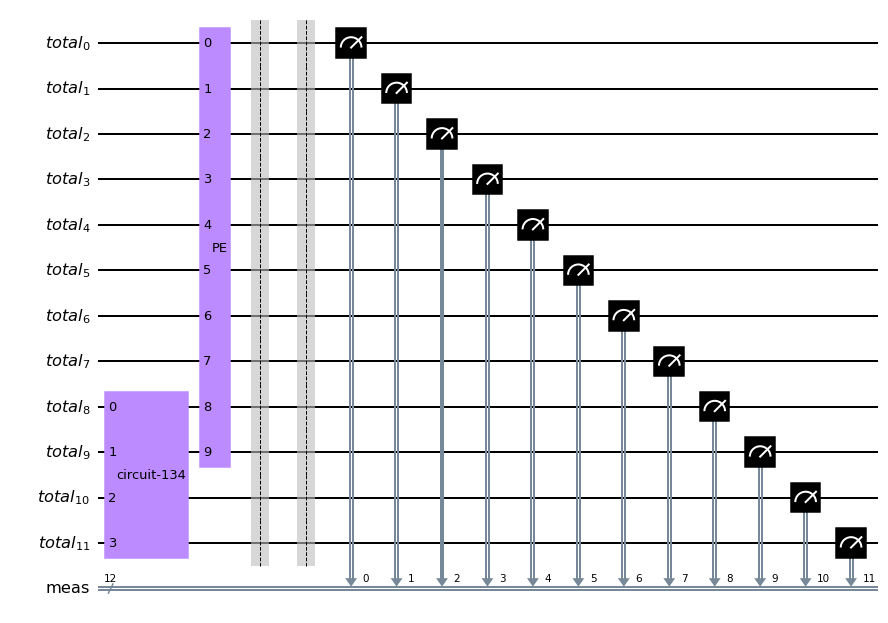

In [18]:
tot_qubit = resolution+len(example_matrix1)

qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
total_circuit.barrier()

total_circuit.measure_all()
total_circuit.draw("mpl")

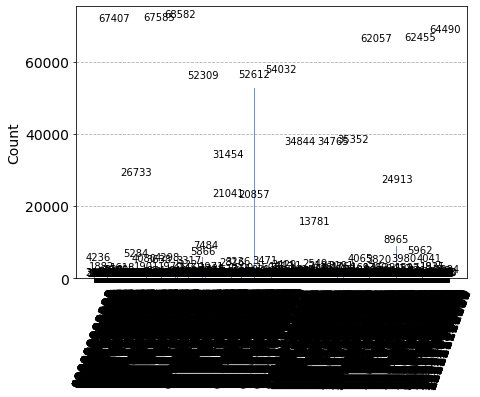

In [19]:
n_shots=1000000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [20]:
for i in counts:
    counts[i]/=n_shots
#counts

In [21]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
#statevector

In [22]:
#Create second operator tomography
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

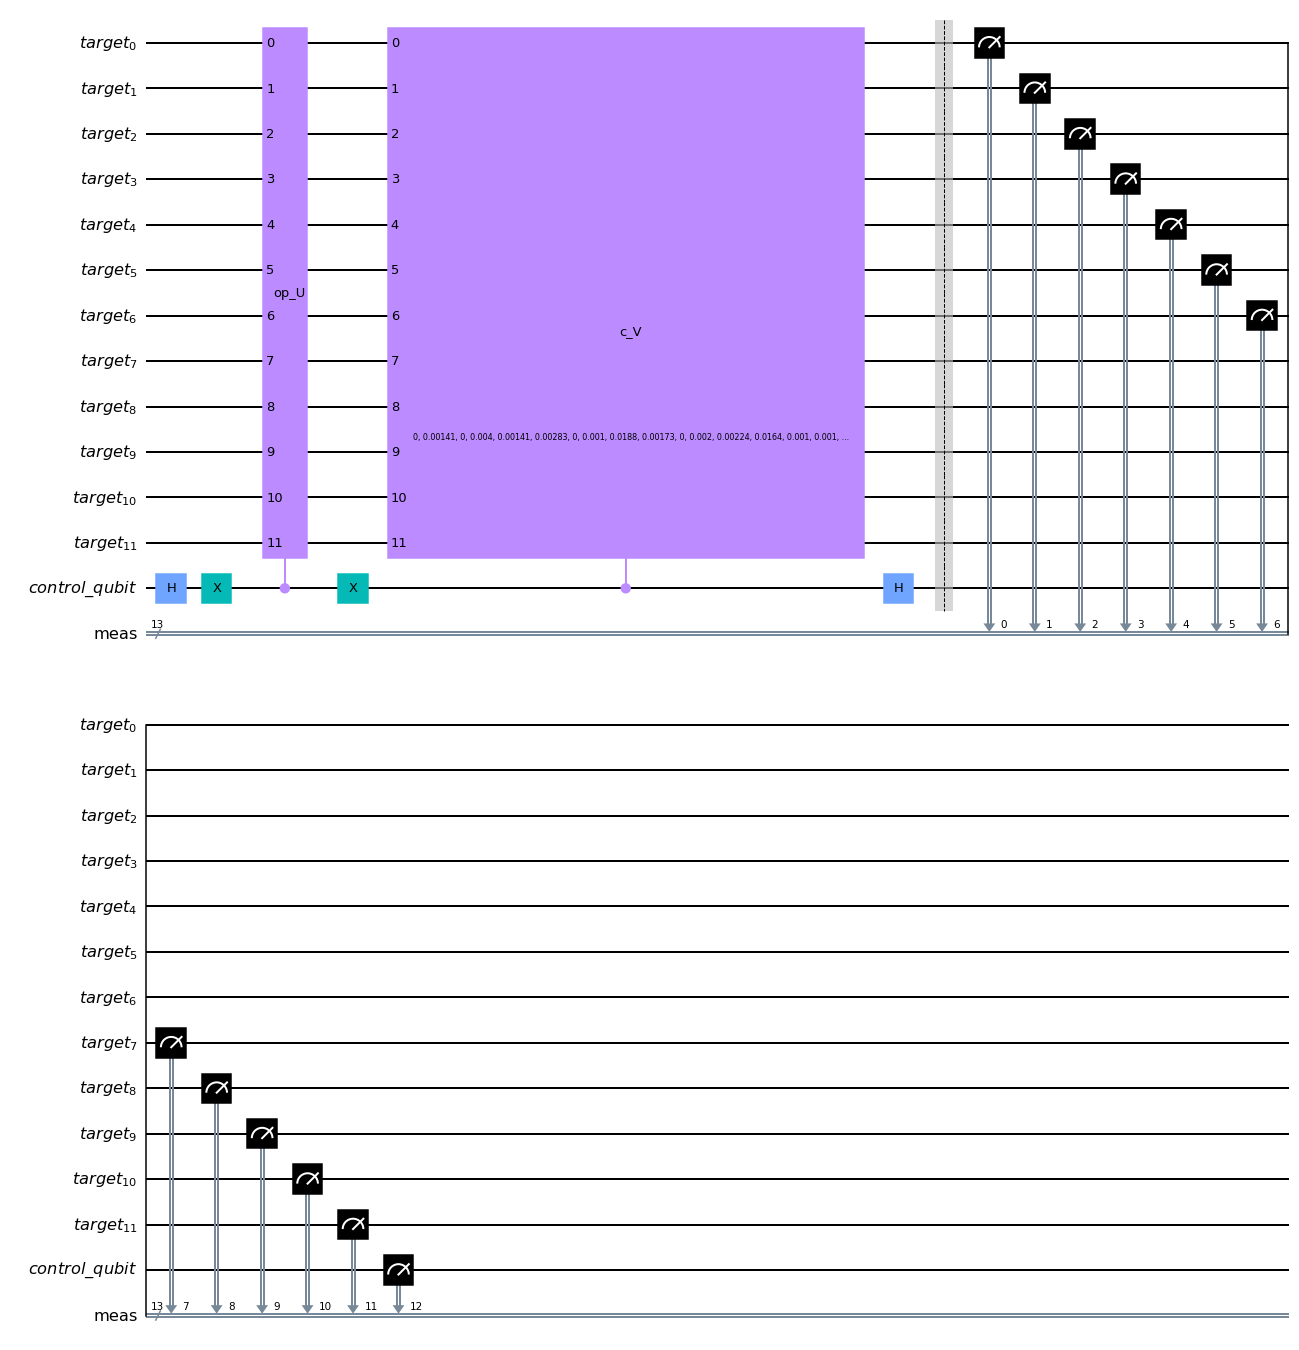

In [23]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)

total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

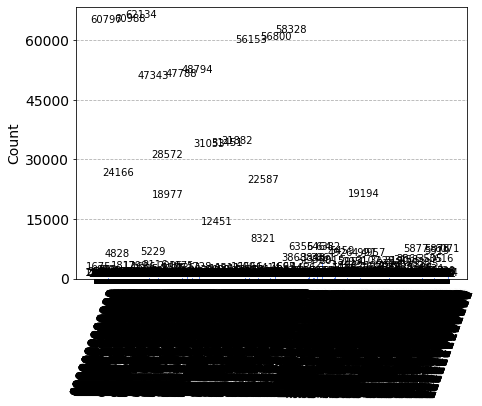

In [24]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [25]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
#tmp

In [2258]:
###Metodo Nannicini

'''tmp_=tmp/(sum(tmp))

sign_diff=[]
sign=[]
x_list=[]
for i in range(len(tmp_)):
    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
    
    x_list.append(x)
    
    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))
    sign.append(np.sign(x))
    '''

'tmp_=tmp/(sum(tmp))\n\nsign_diff=[]\nsign=[]\nx_list=[]\nfor i in range(len(tmp_)):\n    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))\n    \n    x_list.append(x)\n    \n    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))\n    sign.append(np.sign(x))\n    '

In [26]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [27]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

#statevector_dictionary

In [28]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

In [29]:
df=pd.DataFrame(ss)

df.columns=['state','module']
df

,state,module
0,000000000000,0.000000
1,000000000001,0.000002
2,000000000010,0.000000
3,000000000011,0.000016
4,000000000100,0.000002
...,...,...
4091,111111111011,0.000000
4092,111111111100,0.000001
4093,111111111101,0.000023
4094,111111111110,0.000002


In [30]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module',ascending=False)
df1

,module
lambda,
11001101,0.742958
11001100,0.092104
00101101,0.046501
11110000,0.022800
01001101,0.020717
...,...
00000110,0.000006
11110010,0.000006
10010110,0.000006


In [31]:
tail=df1.reset_index()
tail

,lambda,module
0,11001101,0.742958
1,11001100,0.092104
2,00101101,0.046501
3,11110000,0.022800
4,01001101,0.020717
...,...,...
251,00000110,0.000006
252,11110010,0.000006
253,10010110,0.000006
254,10111010,0.000005


In [32]:
tail['num']=tail['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

In [34]:
tail.head(20)

,lambda,module,num
0,11001101,0.742958,0.699219
1,11001100,0.092104,0.199219
2,00101101,0.046501,0.703125
3,11110000,0.022800,0.058594
4,01001101,0.020717,0.695312
5,10101101,0.009210,0.707031
6,01010000,0.008315,0.039062
7,00001000,0.007238,0.062500
8,10001101,0.006056,0.691406
9,00101100,0.005717,0.203125


In [2269]:
'''tail1['num']+=0.1
tail1'''

"tail1['num']+=0.1\ntail1"

In [35]:
np.linalg.eig(example_matrix1)

(array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
 array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
        [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
        [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
        [-0.54730826,  0.17339042,  0.45175377,  0.68286746]]))

In [37]:
peaks=[]
nums_peaks=[]
peaks.append(tail.iloc[0]['lambda'])
nums_peaks.append(tail.iloc[0]['num'])
for i in range(1,len(tail)):
    
    #for n_ in nums_peaks:
        
    if any(abs(tail.iloc[i]['num']-n_)<= 4/(2**resolution) for n_ in nums_peaks):
        #if any(abs(tail1.iloc[i]['num']-n_)/n_<= 0.2 for n_ in nums_peaks):
        pass
    else:
           
        nums_peaks.append(tail.iloc[i]['num'])
        peaks.append(tail.iloc[i]['lambda'])
        pass
    if len(peaks)==len(example_matrix1):
        break
    #print(tail.iloc[i])

In [38]:
peaks,np.array(nums_peaks)

(['11001101', '11001100', '11110000', '01010000'],
 array([0.69921875, 0.19921875, 0.05859375, 0.0390625 ]))

In [39]:
np.linalg.eig(example_matrix2)

(array([0.7 , 0.2 , 0.06, 0.04]),
 array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
        [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
        [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
        [-0.54730826,  0.17339042,  0.45175377,  0.68286746]]))

<AxesSubplot: xlabel='num'>

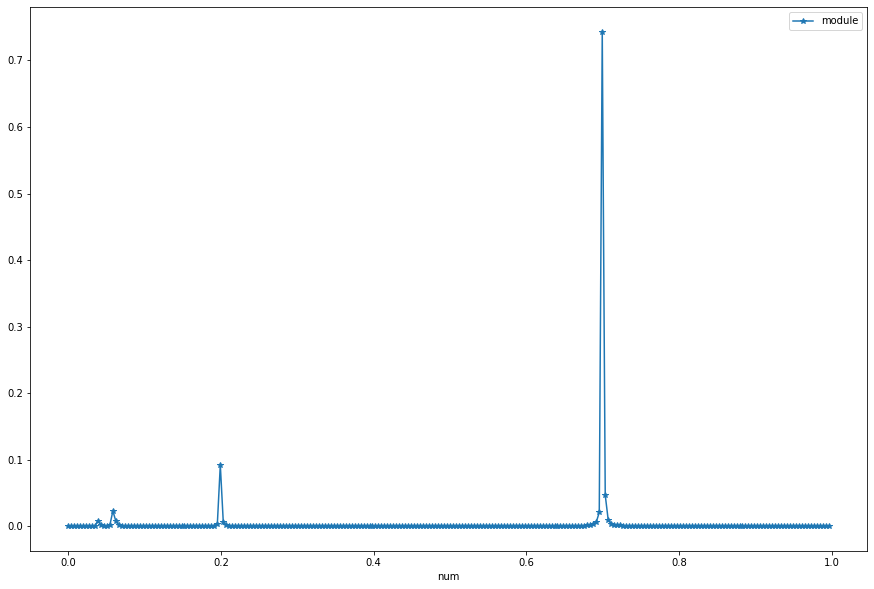

In [41]:
tail[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

In [1434]:
'''lambdas=df1.tail(len(example_matrix1)).index.values
lambdas'''

'lambdas=df1.tail(len(example_matrix1)).index.values\nlambdas'

In [42]:
lambdas=peaks
lambdas

['11001101', '11001100', '11110000', '01010000']

In [44]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,000000000000,0.000000,00000000
1,000000000001,0.000002,00000001
2,000000000010,0.000000,00000010
3,000000000011,0.000016,00000011
4,000000000100,0.000002,00000100
...,...,...,...
4091,111111111011,0.000000,11111011
4092,111111111100,0.000001,11111100
4093,111111111101,0.000023,11111101
4094,111111111110,0.000002,11111110


In [45]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,000000000000,0.000000,00000000,1
1,000000000001,0.000002,00000001,1
2,000000000010,0.000000,00000010,1
3,000000000011,0.000016,00000011,-1
4,000000000100,0.000002,00000100,-1
...,...,...,...,...
4091,111111111011,0.000000,11111011,1
4092,111111111100,0.000001,11111100,-1
4093,111111111101,0.000023,11111101,-1
4094,111111111110,0.000002,11111110,1


In [46]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,000000000000,0.000000,00000000,1
1,000000000001,0.000002,00000001,1
2,000000000010,0.000000,00000010,1
3,000000000011,-0.000016,00000011,-1
4,000000000100,-0.000002,00000100,-1
...,...,...,...,...
4091,111111111011,0.000000,11111011,1
4092,111111111100,-0.000001,11111100,-1
4093,111111111101,-0.000023,11111101,-1
4094,111111111110,0.000002,11111110,1


In [47]:
#df['st']=sim_statevector

In [1903]:
df.query("state.str.endswith('01111000')")

,state,module,lambda,sign
120,0000001111000,0.000000,001111000,1
376,0000101111000,0.000000,101111000,1
632,0001001111000,0.000000,001111000,1
888,0001101111000,-0.000001,101111000,-1
1144,0010001111000,0.000007,001111000,1
1400,0010101111000,0.000002,101111000,1
1656,0011001111000,0.000000,001111000,1
1912,0011101111000,-0.000001,101111000,-1
2168,0100001111000,0.000000,001111000,1
2424,0100101111000,0.000000,101111000,1


In [48]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.25962858 0.16350229 0.25997115 0.26188165 0.22871161 0.14505516
 0.22937306 0.23244784 0.18666548 0.1173925  0.18645375 0.18802128
 0.24911242 0.15783853 0.24990998 0.25394881]
1.1601599478918088
[array([0.30121068, 0.18968881, 0.30160812, 0.3038246 , 0.26534205,
       0.16828719, 0.26610944, 0.26967668, 0.21656181, 0.13619408,
       0.21631617, 0.21813475, 0.28901026, 0.18311794, 0.28993555,
       0.29462124]), array([0.03062679, 0.07269113, 0.06031584, 0.01808314, 0.07658982,
       0.17735276, 0.14441953, 0.04257934, 0.0222486 , 0.05048762,
       0.04012481, 0.01256981, 0.04123106, 0.09468368, 0.07721399,
       0.02209072]), array([0.0338969 , 0.01923538, 0.00141421, 0.02109502, 0.08651012,
       0.053066  , 0.00264575, 0.04928489, 0.03201562, 0.02068816,
       0.00282843, 0.01766352, 0.06180615, 0.03757659, 0.003     ,
       0.03292416]), array([0.00374166, 0.00479583, 0.00714143, 0.00556776, 0.00244949,
       0.00806226, 0.01931321, 0.02332381, 0.00591608, 0.02170253,


In [49]:
eigenvalues

[0.69921875, 0.19921875, 0.05859375, 0.0390625]

In [50]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix1)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix1))):
        max_list.append(max(sv[i:i+len(example_matrix1)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix1)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix1)*idx_max:len(example_matrix1)*idx_max+len(example_matrix1)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig)
    

reconstructed_eigenvector: [0.54646065 0.34413611 0.54718169 0.55120287]
reconstructed_eigenvalue: 0.69921875
reconstructed_eigenvector: [ 0.33012806  0.76445046 -0.62249709 -0.18353137]
reconstructed_eigenvalue: 0.19921875
reconstructed_eigenvector: [-0.75691957  0.46430052  0.02314898  0.43121772]
reconstructed_eigenvalue: 0.05859375
reconstructed_eigenvector: [ 0.07894674 -0.3379068  -0.57408992  0.69455186]
reconstructed_eigenvalue: 0.0390625


In [51]:
np.linalg.eig(example_matrix1),np.linalg.eig(example_matrix2)

((array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])),
 (array([0.7 , 0.2 , 0.06, 0.04]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])))